In [5]:
import os, sys, collections, re, json, io, base64
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import scipy
import statsmodels.formula.api as smapi
import statsmodels.tsa.stattools as ts
import warnings
import scipy
import IPython
import sklearn

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import HTML
from pandas import Series
from IPython.display import display, Math, Latex
from IPython.external import mathjax
from scipy import stats
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas import Series

plt.style.use('ggplot')
plt.rc("savefig", dpi=110)

import gzip, os, sys
#import custom functions for displaying tables, bash commands
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di


from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

<H1 align="center"> Petroleum Inventory Level: <br> <br> A Leading Indicator of Crude Oil Prices  </center></H1> <br> <br><br> 

<center> By: Marcus Larsson </center> 
<center> Email: mla@inocean.se </center>   
<center>Please view in code hidden mode </center> <br> 

### Abstract
This jupyter notebook proposes a long-run forecasting model of the West Texas Intermediate (WTI) crude oil spot price using 
the United States petroleum inventory level. The inventory data used in the model is updated each wednesday 10:30 AM EST, resulting in a new forecasted value for each report. Applying the forecasting model between January 2010 to date, I find that the model delivers persistent long-term performance. The model is useful for those who are interested in forecasting future oil prices or for 
those who wish to understand and interpret historical price fluctuations.

### Introduction
This jupyter notebook presents and evaluates a forecasting model for the WTI spot price. The objective of the notebook is to provide a simple, yet practical forecasting model which can easily be implemented. In order to test the predictive power of the model, I employ out-of-sample forecasting. The result suggests that the petroleum inventory level has been a leading indicator for the crude oil spot price for the last decade. 
### Theory
Intuitively, there should be a negative relationship between the petroleum inventory level and the oil price. The
rationale is that a petroleum inventory change can be interpreted as the result of the imbalance between supply and
demand, and should therefore affect the spot price in an inverse manner. In practise, the relationship between the petroleum inventory
level and the oil price is, however, not directly obvious; as the petroleum inventory level is affected by seasonal movements
and a general trend that tends to mask the connection. The relative inventory level is an indicator that normalizes 
the petroleum inventory level for any deterministic time trend and seasonal variation in production, consumption and refinery 
utilization. The central concept is that if current inventories deviate from their normal level, according to inventory trend 
and seasonal swings, the market is in disequilibrium and prices should react accordingly. The relative inventory level, RIN, is defined as the deviation of the observed petroleum inventory level, IN, 
from a historically determined normal level, IN hat. A time dummy variable, D, is used to extract the seasonal effect from the observed inventory level. 


The observed inventories are de-seasonalized through the following regression. 

$$  ln{(IN_t)} = \alpha_o + \sum_{k=2}^{n}\beta_k D_k + \epsilon_t \tag{1} $$

$$ ln{\widehat{(IN_t)}} = \alpha_o + \sum_{k=2}^{n}\beta_k D_k \tag{2} $$

Once the dummy parameters are estimated, one can extract the seasonal influence of the inventory level, where the
resulting residuals will represent the relative inventory level.

$$ ln{(RIN_t)} = ln{(IN_t)} - ln{(\widehat{IN}_t)}  \tag{3} $$

In [ ]:
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


# EIA Inventory Data (df)
dfInventory = pd.read_excel('http://ir.eia.gov/wpsr/psw01.xls', "Data 1", index_col="Date", parse_dates=["Date"], skiprows=2)

# Historical Spot Price (df3)
dfSpot = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_W.xls', "Data 1", parse_dates=["Date"], index_col="Date", skiprows=[0,1])

# Intrada Spot Price (Df5)
dfIntraSpot = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', "Data 1", parse_dates=["Date"], index_col="Date", skiprows=[0,1])

# Subset
dfInventory = dfInventory["2010":"2050"]
dfSpot = dfSpot["2010":"2050"]
dfIntraSpot = dfIntraSpot["2010":"2050"]

# Create seasonal dummies
dfDummies = pd.get_dummies(dfInventory.index.week)
dfDummies.index = dfInventory.index
dfInventory = pd.concat([dfInventory, dfDummies], axis= 1)                          
                          
# Rename cols
dfInventory_cols = ['crude_oil','crude_oil_no_spr','crude_in_spr','gasoline','reformulated_gasoline','conventional_gasoline','blending_gasoline','fuel_ethanol','jet_fuel','distillate', 'distillate_15ppm','distillate_500ppm','distillate_500+ppm','residual_oil','propane_propylene','other_oils','unfinished_oils','Inventory','crude_products_no_spr', 'W1','W2', 'W3', 'W4', 'W5', 'W6', 'W7','W8','W9' ,'W10' ,'W11' ,'W12' ,'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'W19', 'W20', 'W21', 'W22', 'W23', 'W24', 'W25', 'W26', 'W27', 'W28', 'W29', 'W30', 'W31', 'W32', 'W33', 'W34', 'W35', 'W36', 'W37', 'W38', 'W39', 'W40', 'W41', 'W42', 'W43', 'W44', 'W45', 'W46', 'W47', 'W48', 'W49', 'W50', 'W51', 'W52', 'W53']
dfInventory.columns = dfInventory_cols                          

dfSpot_cols = ['WTI', 'Brent']
dfSpot.columns = dfSpot_cols

dfIntraSpot_cols = ['WTI_daily', 'Brent_daily']
dfIntraSpot.columns = dfIntraSpot_cols 

In [ ]:
# Log Transformation
dfInventory['IP_log']= np.log(dfInventory.Inventory)

# Linear Regression
m1 = smapi.OLS.from_formula('IP_log ~ W1 +W2+ W3+ W4+ W5+ W6+ W7+ W8+ W9+ W10+ W11+ W12+ W13+ W14+ W15+ W16+ W17+ W18+ W19+ W20+ W21+ W22+ W23+ W24+ W25+ W26+ W27+ W28+ W29+ W30+ W31+ W32+ W33+ W34+ W35+ W36+ W37+ W38+ W39+ W40+ W41+ W42+ W43+ W44+ W45+ W46+ W47+ W48+ W49+ W50+ W51+ W52+ W53 -1', dfInventory).fit()

# Predict Residuals
dfInventory['RIN'] = m1.resid

# Concat Inventory Data with Weekly Spot Price 
df = pd.concat([dfInventory, dfSpot], axis= 1)

In [ ]:
# @hidden_cell

sns.set_style("white")
sns.set_style("ticks")
fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=90)
ax1 = df['WTI'].plot(label='WTI Spot Price')
ax2 = df['RIN'].plot(secondary_y=True, label='Relative Inventory Level')
ax2 = plt.gca()
ax2.invert_yaxis()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=1, frameon=False)
plt.figtext(0.137, 0.14, "Data Source: EIA Weekly Petroleum Status Report", fontsize= 10)
plt.suptitle('Figure 1: The WTI Spot Price and the Relative Inventory Level', x=0.5, y=0.95, ha='center', fontsize='x-large')
plt.figtext(0.04, 0.5, 'Dollars per Barrel', va='center', rotation='vertical', fontsize=11)
plt.figtext(1.005, 0.5, 'Log Million Barrels', va='center', rotation='vertical', fontsize=11)
plt.style.use('ggplot')
plt.show()
corr = df['WTI'].corr(df['RIN'])
print('PearsonR Correlation Coefficient:',round(corr, 3),'(WTI & RIN)') 

In [ ]:
# Square relative inventory
df['RINsqr']= df['RIN']**2

# Predict forecast
m2 = smapi.OLS.from_formula('WTI ~ RIN + RINsqr', df).fit()
df['Forecast'] = m2.fittedvalues

# Create year variable to hue by year
df.reset_index(inplace=True)
df['Year'] = df['Date'].dt.year
df.set_index('Date', inplace=True)
df.ix[-1,'Year'] = 'Latest Week'

# Substitue "Latest Week" observation to intraday spot price
df.ix[-1,'WTI'] = dfIntraSpot.ix[-1,'WTI_daily']

##### Non-linearity Between Relative Inventory and the Spot Price  

A minimum operating level of petroleum inventory is essential to keep the North American supply system operating;
pipeline systems need a cushion level of inventory to keep the system running, road tankers and railcars need fuel to link 
the production sites, and terminals and refineries need a base level to operate. Due to the economy requiring a minimum 
operating level of petroleum inventories, the relationship between the inventory level and the spot price is intrinsically 
non-linear. That is, if the inventory level were to approach its minimum operating level, prices should
in theory react in a non-linear fashion (increase exponentially) to compensate for the risk associated with a stock out. Petroleum 
inventories can also be viewed as being limited due to infrastructure constraints. Once the inventory surplus breaches
logistical and spare storage capacity, oil prices should converge to marginal cost and force producers
to stop producing. U.S. shale wells can have a variable cost below 15 dollars a barrel, resulting in that their owners
will keep on producing even if spot prices are below the producers average cost.

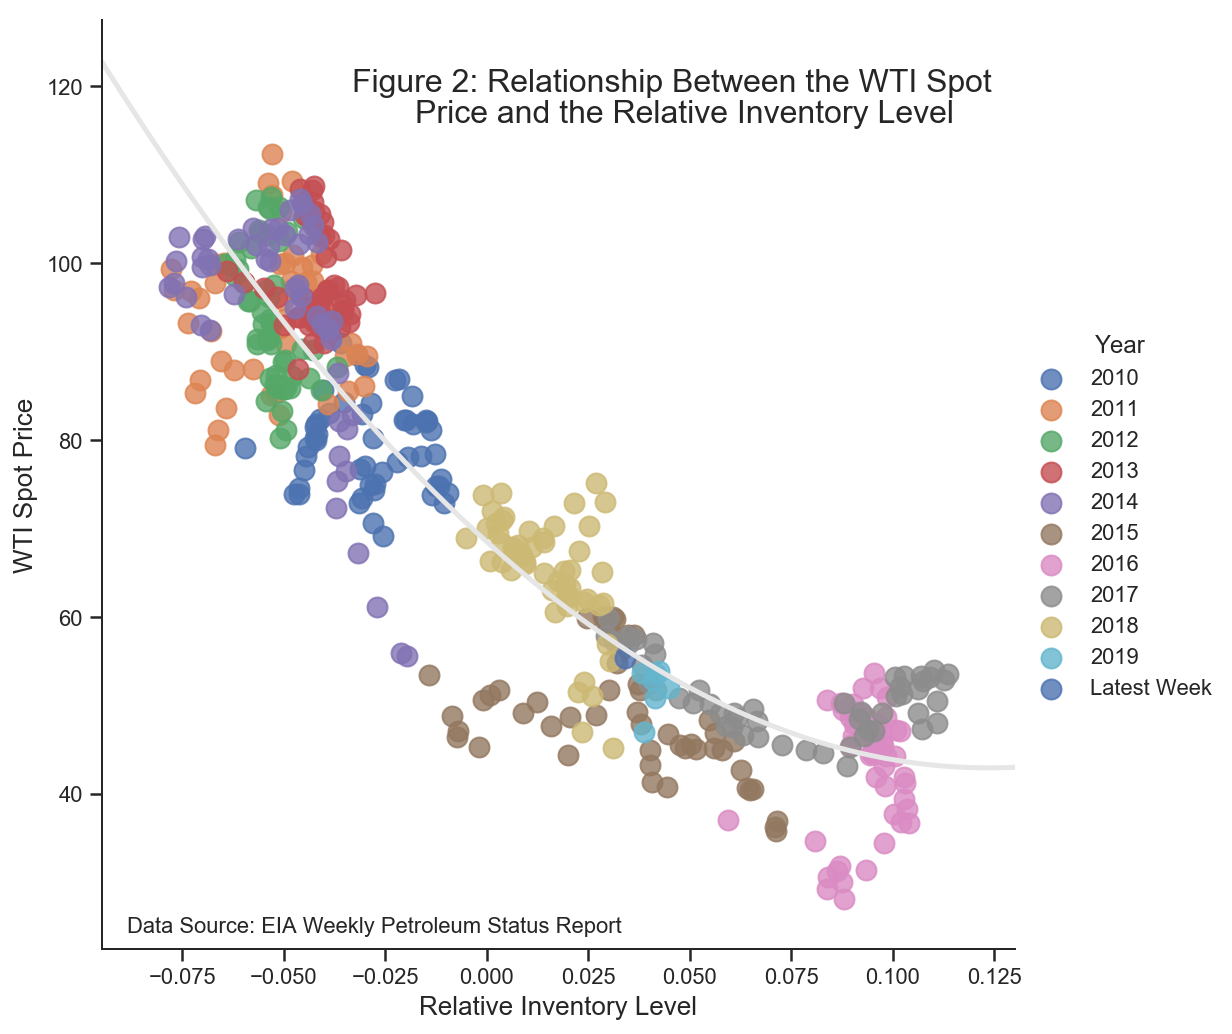

PearsonR Correlation Coefficient: 0.92 (WTI & Fitted line)
R2, Coefficient of Determination: 0.846


In [65]:
sns.set_style("white")
sns.set_style("ticks")
plot1 = sns.lmplot(x="RIN", y="WTI", data=df, hue='Year', fit_reg=False,  
        
    height = 7.3, aspect = 1, palette="deep",
    order=2, ci=None,  scatter_kws={"s": 100});

plot1 = sns.regplot("RIN", "WTI", data=df, color=".9", scatter=False, order=2, ci=None, line_kws={"lw":2.5});


csfont = {'fontname':'Times New Roman'}

plt.figtext(0.12, 0.10, "Data Source: EIA Weekly Petroleum Status Report", fontsize= 11)
plt.figtext(0.30, 0.9, "Figure 2: Relationship Between the WTI Spot", fontsize= 16)
plt.figtext(0.35, 0.87, "Price and the Relative Inventory Level", fontsize= 16)
plt.xlabel("Relative Inventory Level", fontsize = 13)
plt.ylabel('WTI Spot Price', fontsize = 13)
plt.show()

corr = df['Forecast'].corr(df['WTI'])
r2 = corr * corr

print('PearsonR Correlation Coefficient:',round(corr, 3),'(WTI & Fitted line)')
print('R2, Coefficient of Determination:',round(r2, 3))
# plt.savefig('plot_name.png', dpi = 1000)

Figure 2 above, demonstrate the non-linear relationship between the WTI spot price and the relative inventory level. On 
the vertical axis, the WTI spot price is shown in U.S. dollars per barrel and on the horizontal axis, the U.S. relative
inventory level is shown in natural logarithmic scale. The fitted gray line is equivalent to the long-run forecasting model. The upper 
and lower bound of petroleum inventories - created by infrastructure constraints and the minimum operating level - contributes 
with a steeper curvature at the extreme points. In essence, the 
market recognize whether the prevailing storage level is sustainable or not and adjusts the WTI price accordingly. The price 
is thus the mechanism the market employs to secure adequate supply and to discourage the maintenance of surplus supply.

### Model  
In this section, I present the relative inventory model that is used to predict the oil price. The model rests on the notion that the price
of oil is determined by the equilibrium between supply and demand in the physical market. The purpose of the forecast is not to predict short-run changes in the spot, but
to separate the short-term noise from the long-run signal. When creating a short-run forecasting model, an ARIMA-model would be more appropriate. 

In equation 4, the relative inventory model is expressed as:

$$ WTI_t = \alpha_o + \beta_1 RIN_{t-1} + \beta_1 {RIN^2}_{t-1} + \mu_t \tag{4} $$ 

where WTI is the average weekly WTI spot price at time t and RIN is the relative inventory level a period
before. A squared variable of the relative inventory level is added to capture the non-linear dynamic between oil prices and 
petroleum inventories.

### Data
A database covering petroleum inventory is a prerequisite for this work. The International Energy Agency (IEA)
and the U.S. Energy Information Administration (EIA) provides the most comprehensive data in terms of quality,
nations covered, consistency of reporting and detailed used. I will use the EIA Weekly Petroleum Status Report, as
the data is readily available online for anyone to reach. The EIA data set is published on a weekly basis, and covers
U.S. petroleum inventories by Petroleum Administration for Defense District (PADD). I chose to limit the
data to the United States, as I hypothesize that the U.S. inventory level has grown to be the most imperative region
in its predictive power of the WTI spot price. 

The Petroleum inventory level represent the amount of inventory of crude oil and petroleum products held in
inventory for future use. Inventories are accounted for on a national territory basis, within a country’s geographical
region and irrespective of ownership. Granted that the inventories are held on the national territory, it does not
matter whether the inventories are held onshore, offshore, at refineries or in pipelines. The inventory level is
measured by the EIA-813 Crude Oil Report, which requires companies that carry or store 1,000 barrels or
more to submit information regarding all domestic and foreign inventories held in custody and in transit thereto.
The petroleum inventory consists of crude oil, which represent the liquid that is extracted from the geological
formation, and petroleum products, which are produced from the processing of crude oil. Petroleum inventories
can further be divided into commercial inventories, which represent petroleum inventories held for commercial
purposes by U.S. firms, and strategic inventories, which represent petroleum inventories maintained by the Federal
Government. 

For the crude oil spot price, I use West Texas Intermediate (WTI), which together with Brent are considered the
world’s benchmark for crude oil prices. WTI is the crude oil specified for delivery to Cushing, Oklahoma under the
New York Mercantile Exchange (NYMEX) futures contract, which makes WTI the proper benchmark to compare
with U.S. petroleum inventories. 

### Empirical Results

In order to test the predictive power of the model, I employ out-of-sample forecasting. 
I split the dataset into 70/30%, with the first period being defined as in-sample and the later period being defined 
as out-of-sample.

In [66]:
X = df[['RIN', 'RINsqr']]
y = df['WTI']

# Sperate train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False) # random_state=0

# 1. Set up the model
model = LinearRegression()

# 2. Use fit
model.fit(X_train, y_train)

# 3. Check the score
model.score(X_train, y_train)
model.score(X_test, y_test)

model.coef_ # Get the coefficients, beta

model.intercept_ # Get the intercept, c

# prediction in & out-of-sample
y_pred_test = model.predict(X_test) 
y_pred_train = model.predict(X_train) 

df_train_prediction = pd.DataFrame(y_pred_train)
df_test_prediction = pd.DataFrame(y_pred_test)

In [67]:
# Split data into 0.7/0.3
series = df[['RIN']]
Z = series.values
train_size = int(len(Z) * 0.7)
train_RIN, test_RIN = Z[0:train_size], Z[train_size:len(Z)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train_RIN)))
print('Testing Observations: %d' % (len(test_RIN)))

series = df[['WTI']]
Y = series.values
train_size = int(len(Y) * 0.7)
train_WTI, test_WTI = Y[0:train_size], Y[train_size:len(Y)]

series = df[['RINsqr']]
Z = series.values
train_size = int(len(Z) * 0.7)
train_RINsqr, test_RINsqr = Z[0:train_size], Z[train_size:len(Z)]

# In-Sample
dftrain = pd.DataFrame(train_WTI, columns=["train_WTI"])
dftrain['train_RIN'] = train_RIN
dftrain['train_RINsqr'] = train_RINsqr

# Out-of Sample
dftest = pd.DataFrame(test_WTI, columns=["test_WTI"])
dftest['test_RIN'] = test_RIN
dftest['test_RINsqr'] = test_RINsqr

traindate = df.index
traindate1 = pd.DataFrame(traindate)
dftrain1 = pd.concat([traindate1, dftrain], axis= 1)
dftrain2 = dftrain1.dropna()
dftrain2.set_index('Date', inplace=True)

testdate1 = df.index
over, under = np.array_split(testdate1, 2)
under = pd.DataFrame(under)
dftest1 = pd.concat([under, dftest], axis= 1)
dftest2 = dftest1.dropna()
dftest2.set_index('Date', inplace=True)

df_train_prediction.index = dftrain2.index
df_train_prediction_cols = ['train']
df_train_prediction.columns = df_train_prediction_cols
dftrain2['train'] = df_train_prediction['train']

df_test_prediction.index = dftest2.index
df_test_prediction_cols = ['test']
df_test_prediction.columns = df_test_prediction_cols
dftest2['test'] = df_test_prediction['test']

Observations: 478
Training Observations: 334
Testing Observations: 144


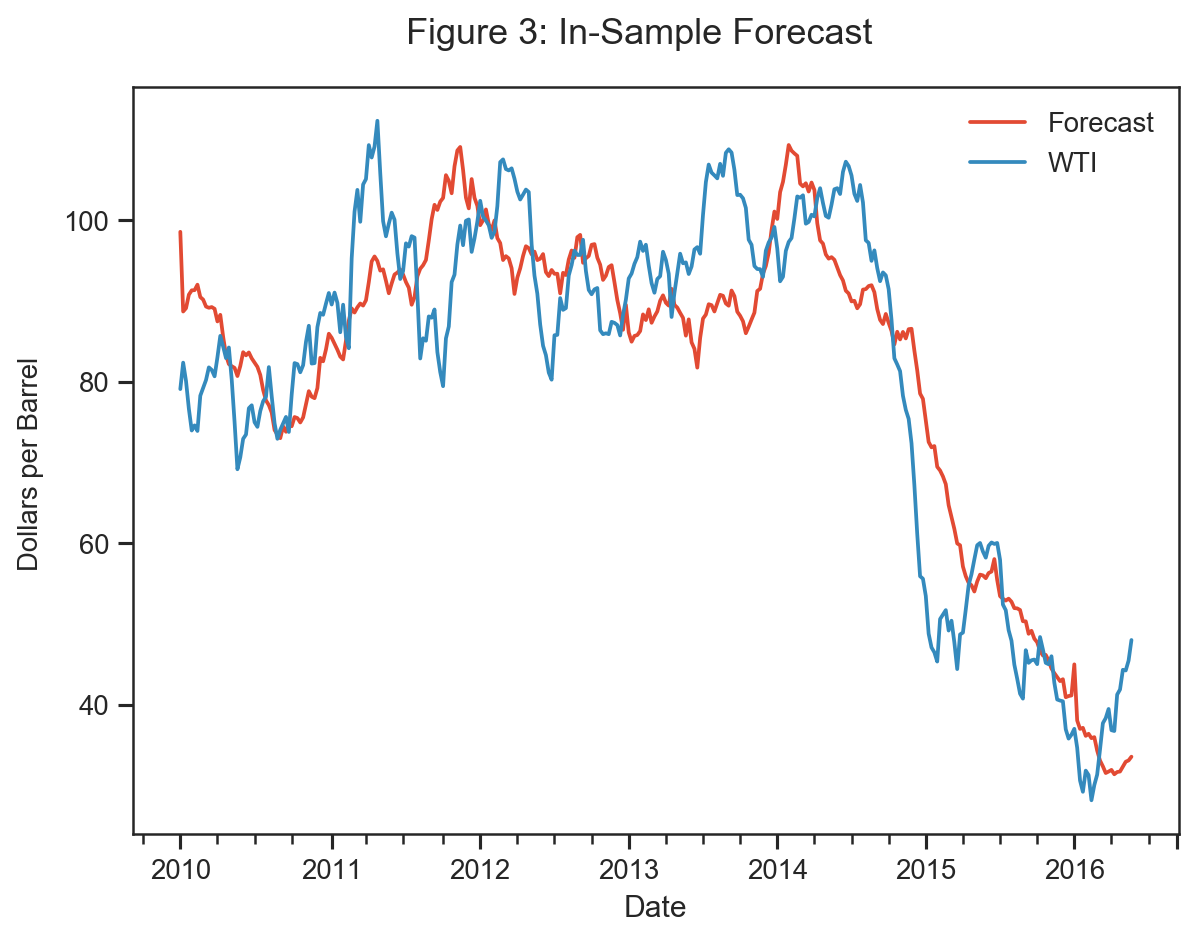

,RMSE,MSE,CORR,R2
,,,,
Forecast,9.504,90.334,0.899,0.808


In [68]:
fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=90)
sns.set_style("ticks")
plt.suptitle('Figure 3: In-Sample Forecast', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax1 = dftrain2['train'].plot(label='Forecast')
ax1 = dftrain2['train_WTI'].plot(secondary_y=False, label='WTI')
ax1 = plt.gca()
plt.figtext(0.04, 0.5, 'Dollars per Barrel', va='center', rotation='vertical', fontsize=11)
plt.legend(frameon=False)
sns.set_style("white")
plt.show()

df['lag_wti']= df['WTI'].shift(1) 

dfoutput1 = (((dftrain2['train'] - dftrain2['train_WTI']) ** 2).mean() ** .5)
dfoutput2 = ((dftrain2['train'] - dftrain2['train_WTI']) ** 2).mean()
dfoutput3 = dftrain2['train_WTI'].corr(dftrain2['train'])
dfoutput4 = (dftrain2['train_WTI'].corr(dftrain2['train'])**2)

d = {'': ['Forecast'], 'RMSE': [dfoutput1], 'MSE': [dfoutput2], 'CORR': [dfoutput3], 'R2': [dfoutput4] }

dfFinal = pd.DataFrame(data=d)
dfFinal.set_index('', inplace=True)
display(round(dfFinal,3))

Figure 3 above demonstrates the long-run forecast and the spot WTI price for the in-sample period. 
On the vertical axis, the WTI spot price is shown in U.S. dollars per barrel. The table displays the root mean square error, the mean square error, the PearsonR correlation coefficient and the coefficient of determination between the forecast and the WTI spot price for the in-sample period.

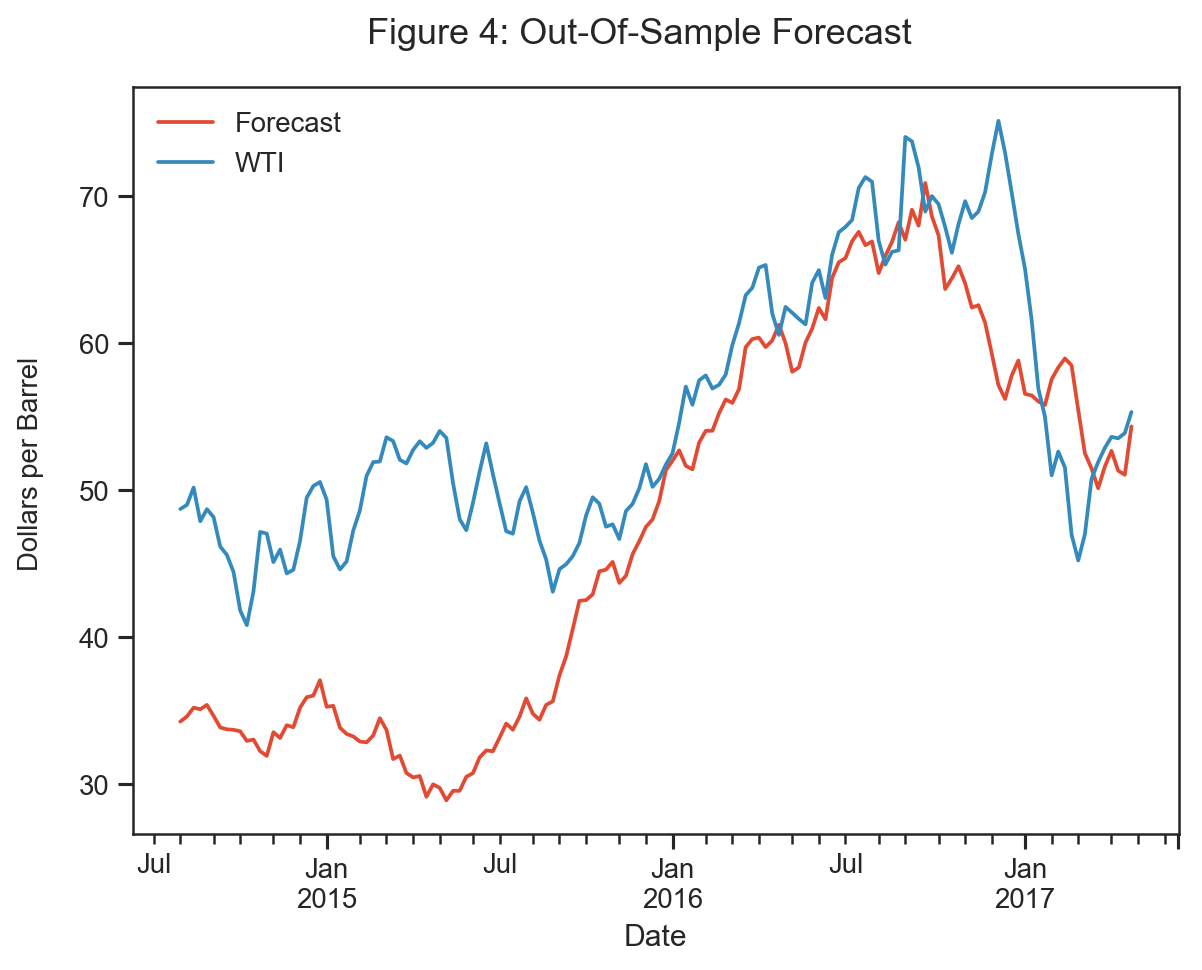

,RMSE,MSE,CORR,R2
,,,,
Forecast,10.887,118.529,0.832,0.692


In [69]:
# Out-Of-Sample
sns.set_style("ticks")
fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=90)
plt.suptitle('Figure 4: Out-Of-Sample Forecast', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax1 = dftest2['test'].plot(label='Forecast')
ax1 = dftest2['test_WTI'].plot(secondary_y=False, label='WTI')
ax1 = plt.gca()
plt.figtext(0.04, 0.5, 'Dollars per Barrel', va='center', rotation='vertical', fontsize=11)
plt.legend(frameon=False)
sns.set_style("white")
plt.show()

dftest2['lag_wti']= dftest2['test_WTI'].shift(1) 

dfoutput11 = (((dftest2['test'] - dftest2['test_WTI']) ** 2).mean() ** .5)
dfoutput22 = ((dftest2['test'] - dftest2['test_WTI']) ** 2).mean()
dfoutput33 = dftest2['test_WTI'].corr(dftest2['test'])
dfoutput44 = (dftest2['test_WTI'].corr(dftest2['test'])**2)


d = {'': ['Forecast'], 'RMSE': [dfoutput11], 'MSE': [dfoutput22], 'CORR': [dfoutput33], 'R2': [dfoutput44] }

dfFinal1 = pd.DataFrame(data=d)
dfFinal1.set_index('', inplace=True)
display(round(dfFinal1,3))

Figure 4 above illustrates the long-run forecast and the spot WTI price for the out-of-sample period. 
On the vertical axis, the WTI spot price is shown in U.S. dollars per barrel. The table displays the root mean square error, the mean square error, the PearsonR correlation coefficient and the coefficient of determination between the forecast and the WTI spot price for the out-of-sample period.

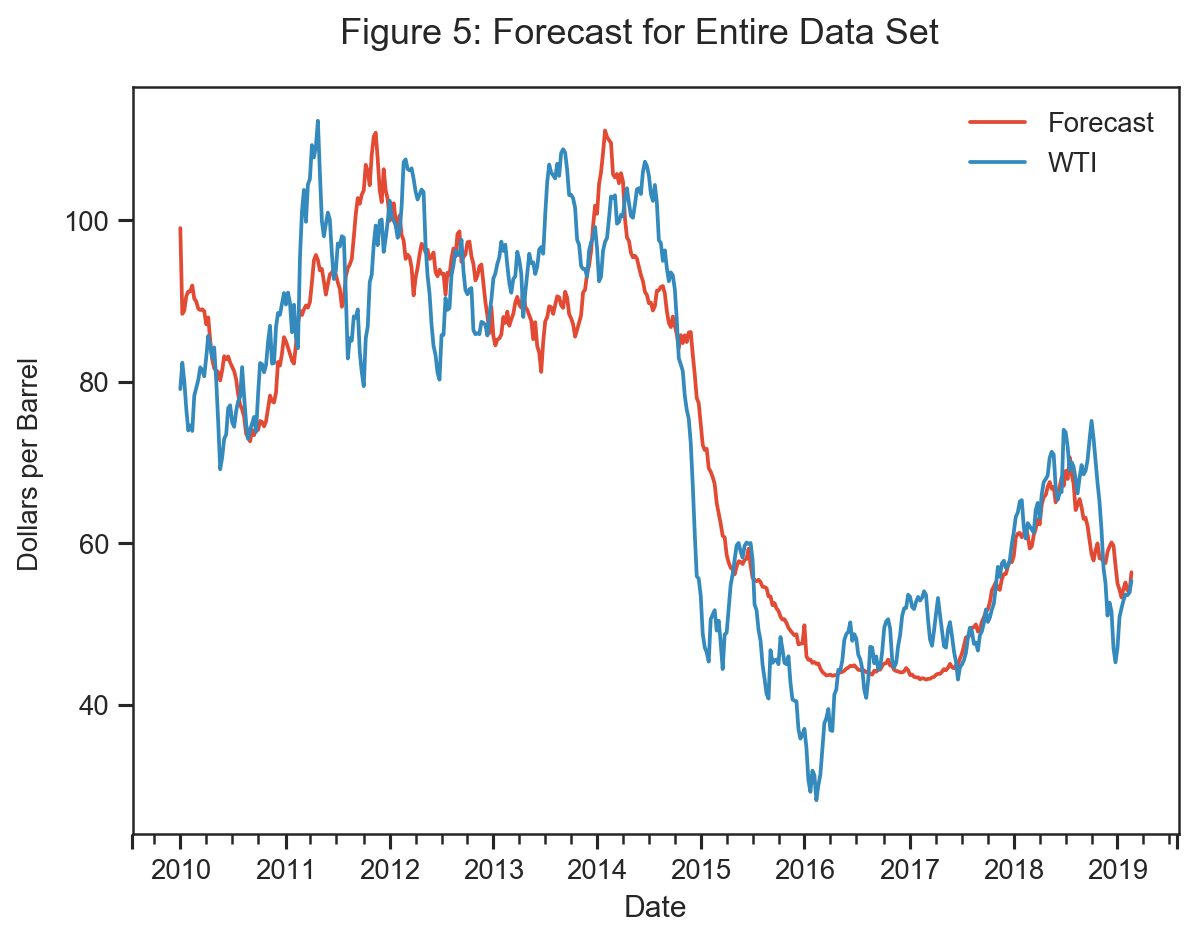

,RMSE,MSE,CORR,R2
,,,,
Forecast,8.776,77.021,0.92,0.846


In [70]:
fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=90)
sns.set_style("ticks")
plt.suptitle('Figure 5: Forecast for Entire Data Set', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax1 = df['Forecast'].plot(label='Forecast')
ax1 = df['WTI'].plot(secondary_y=False, label='WTI')
ax1 = plt.gca()
plt.figtext(0.04, 0.5, 'Dollars per Barrel', va='center', rotation='vertical', fontsize=11)
plt.legend(frameon=False)
sns.set_style("white")
plt.show()

df['lag_wti']= df['WTI'].shift(1) 

dfoutput111 = (((df['Forecast'] - df['WTI']) ** 2).mean() ** .5)
dfoutput222 = ((df['Forecast'] - df['WTI']) ** 2).mean()
dfoutput333 = df['WTI'].corr(df['Forecast'])
dfoutput444 = (df['WTI'].corr(df['Forecast'])**2)


d = {'': ['Forecast'], 'RMSE': [dfoutput111], 'MSE': [dfoutput222], 'CORR': [dfoutput333], 'R2': [dfoutput444] }

dfFinal2 = pd.DataFrame(data=d)
dfFinal2.set_index('', inplace=True)
display(round(dfFinal2,3))

Figure 5 above illustrates the long-run forecast and the spot WTI price for the entire sample. 
On the vertical axis, the WTI spot price is shown in U.S. dollars per barrel. The table displays the root mean square error, the mean square error, the PearsonR correlation coefficient and the coefficient of determination between the forecast and the WTI spot price for the entire dataset.

In [71]:
print("The table above demonstrates the last 5 forecasted values for the long-run forecast.")
print("At the moment, the long-run forecast suggests a fair value of", round(df.ix[-1,'Forecast'], 2), "dollars per barrel for the WTI spot price.") 

if df.ix[-1,'Forecast'] > df.ix[-1,'WTI']:
     print("The forecasted value is", round((df.ix[-1,'Forecast'] - df.ix[-1,'WTI']),2), "dollars per barrel above the average weekly WTI spot price")    
else:
     print("The forecasted value is", round((df.ix[-1,'WTI'] - df.ix[-1,'Forecast']),2), "dollars per barrel below the average weekly WTI spot price")
   
round(df[['WTI', 'Forecast', 'RIN', 'Inventory']].tail(5),3)

The table above demonstrates the last 5 forecasted values for the long-run forecast.
At the moment, the long-run forecast suggests a fair value of 56.38 dollars per barrel for the WTI spot price.
The forecasted value is 1.06 dollars per barrel above the average weekly WTI spot price


,WTI,Forecast,RIN,Inventory
Date,,,,
2019-01-25,52.88,54.330,0.041,1911476.0
2019-02-01,53.63,55.118,0.038,1908119.0
2019-02-08,53.53,54.129,0.042,1914651.0
2019-02-15,53.88,53.924,0.043,1912165.0
2019-02-22,55.32,56.381,0.034,1894292.0


### Credits 
Michael Yea, John Zyren, Mehrzad Zamani, Antonio Merino, Álvaro Ortiz, Michael Bodell, Art Berman, Jeff Currie

### Appendix

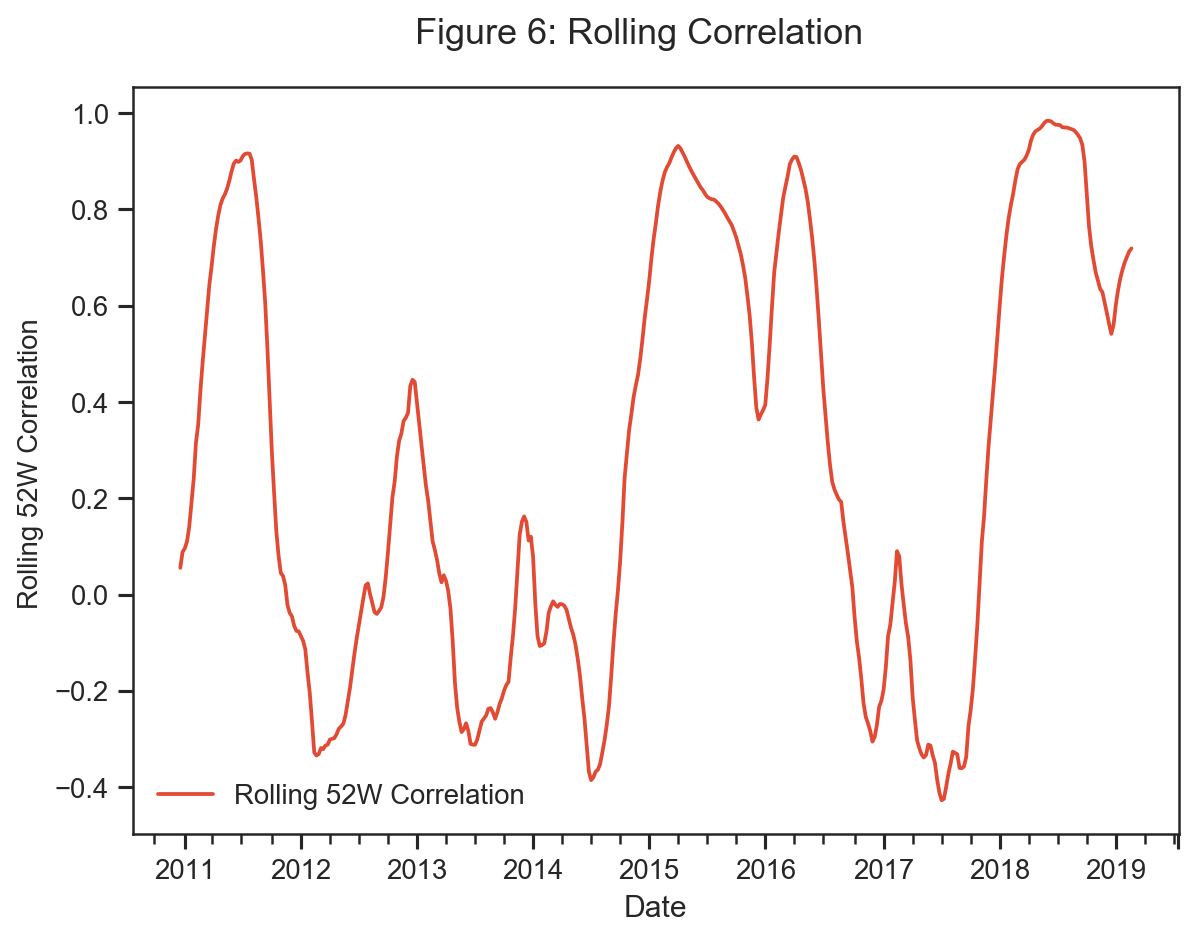

In [72]:
df['corr'] = df['WTI'].rolling(window=52).corr(df['Forecast'])
df['rollingmean'] = pd.Series.rolling(df['Forecast'], window=20).mean()
df['STD'] = pd.Series.rolling(df['WTI'], window=52).std()

fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=90)
sns.set_style("ticks")
plt.suptitle('Figure 6: Rolling Correlation', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax1 = df['corr'].plot(label='Rolling 52W Correlation')
# ax2 = df20['STD'].plot(secondary_y=True, label='WTI Standard Deviation')
plt.figtext(0.04, 0.5, 'Rolling 52W Correlation', va='center', rotation='vertical', fontsize=11)
# plt.figtext(1.005, 0.5, 'Standard Deviation', va='center', rotation='vertical', fontsize=11)
ax2 = plt.gca()

#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()
plt.legend(loc=3, frameon=False)
#plt.legend(h1+h2, l1+l2, loc=2, frameon=False)
plt.show()